In [1]:
import bnpy
import numpy as np
import os
import copy
import matplotlib.pyplot as plt
import seaborn as sns

FIG_SIZE = (15, 8)
plt.rcParams['figure.figsize'] = FIG_SIZE
# %qtconsole

# dataset_path = os.path.join('..', 'data')
# all_data = bnpy.data.XData.read_csv(os.path.join(dataset_path, 'anomaly0245.csv'))

/home/jun/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
%qtconsole

# Prepare Data

Create training data and new batch data for simple test.

In [2]:
dataset_path = os.path.join('/home/torenvln/git/bnp-anomaly/', 'data')
all_data = bnpy.data.XData.read_csv(os.path.join(dataset_path, 'anomaly0245.csv'))
train_dataset = all_data.make_subset(example_id_list=list(range(100000,150000)))
new_batch = all_data.make_subset(example_id_list=list(range(150000, 200000)))

FileNotFoundError: [Errno 2] File /home/torenvln/git/bnp-anomaly/data/anomaly0245.csv does not exist: '/home/torenvln/git/bnp-anomaly/data/anomaly0245.csv'

In [3]:
###############################################################################
# Generate time series with regime switching.
num_regime = 3
regime_noise = [0.1, 5, 1]
regime_loc = [10,5,0]
num_ts_samp = 5000  # number of data point
prop = [0.5, 0.3, 0.2]  # proportion of time in a regime

In [5]:
obs = []
cur_num = 0
while cur_num <= num_ts_samp:
    new_samp = np.random.poisson(100)
    reg_choice = np.random.randint(3)
    reg_obs = np.random.normal(regime_loc[reg_choice], regime_noise[reg_choice], new_samp)
    obs.append(reg_obs)
    cur_num += new_samp

In [6]:
obs = np.concatenate(obs)

In [7]:
train_dataset = bnpy.data.XData(obs.reshape(-1,1))

In [8]:
new_obs = np.random.normal(0, regime_noise[0], 100) + regime_loc[0]

In [9]:
new_batch = bnpy.data.XData(new_obs.reshape(-1,1))

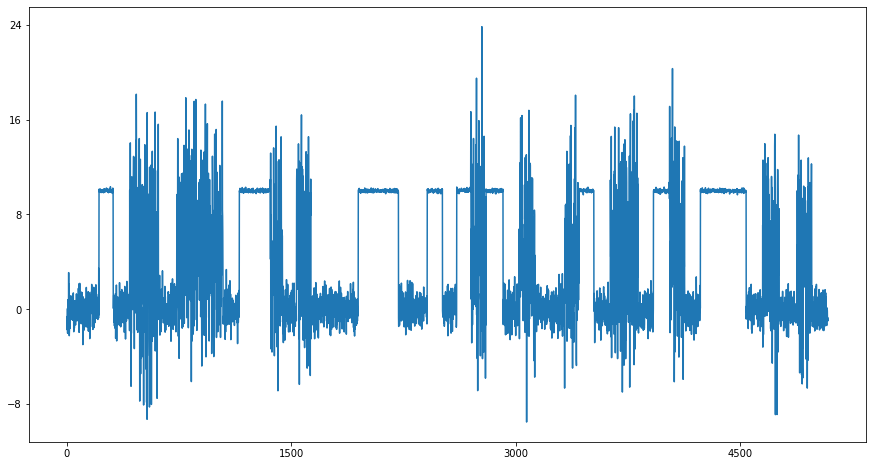

In [10]:
plt.plot(obs)
plt.show()

# Train model

Lots of hyper-parameters that can be tuned and changed to improve model learning.

In [11]:
###############################################################################
#
# *DiagGauss* observation model
# --------------------------------------------
#

gamma = 1.0
sF = 1.0
K = 10  # Initialize K component

trained_model, info_dict = bnpy.run(
    train_dataset, 'DPMixtureModel', 'DiagGauss', 'memoVB',
    output_path=f'/tmp/faithful/trymoves-K={K}-gamma={gamma}-lik=DiagGauss-ECovMat={sF}*eye-moves=none/',
    nLap=10, nTask=1, nBatch=100, convergeThr=0.0001,
    gamma0=gamma, sF=sF, ECovMat='eye',
    moves='birth,merge,delete,shuffle',
    K=K, initname='randexamplesbydist', ts=True)

  --ts
Dataset Summary:
X Data
  total size: 5087 units
  batch size: 51 units
  num. batches: 100
Allocation Model:  DP mixture with K=0. Concentration gamma0= 1.00
Obs. Data  Model:  Gaussian with diagonal covariance.
Obs. Data  Prior:  independent Gauss-Wishart prior on each dimension
  Wishart params 
    nu = 3 
  beta = [ 1] 
  Expectations
  E[  mean[k]] = 
  [ 0]
  E[ covar[k]] = 
  [[1.]]
Initialization:
  initname = randexamplesbydist
  K = 10 (number of clusters)
  seed = 1607680
  elapsed_time: 0.0 sec
Learn Alg: memoVB | task  1/1 | alg. seed: 1607680 | data order seed: 8541952
task_output_path: /tmp/faithful/trymoves-K=10-gamma=1.0-lik=DiagGauss-ECovMat=1.0*eye-moves=none/1
MERGE @ lap 1.00: Disabled. Cannot plan merge on first lap. Need valid SS that represent whole dataset.
DELETE @ lap 1.00: Disabled. Cannot delete before first complete lap, because SS that represents whole dataset is required.
    0.010/10 after      0 sec. |    168.0 MiB | K   10 | loss  2.552374899e

# New Operations  

- Only done on replacing the batchSS.
- There are SS specific copy operations, find out and used them  
- [] Figure out calculation of propXSS which is needed for anomaly detection.

In [12]:
# Get the learned SS from model and info dict

S_k0 = copy.deepcopy(info_dict["SS"])  # This is the S_k0, sufficient statistics of the component of entire dataset
SSmemory = copy.deepcopy(info_dict["SSmemory"])  # Dictionary of SS for all batches

In [16]:
vars(trained_model.obsModel.Post)

{'K': 7,
 'D': 1,
 '_FieldDims': {'nu': 'K', 'kappa': 'K', 'm': ('K', 'D'), 'beta': ('K', 'D')},
 'doCollapseK1': False,
 'nu': array([2221.15623475, 1332.37679546,  728.83355221,  371.40288251,
         220.61533857,  152.78537918,   84.82981732]),
 'kappa': array([2218.15633475, 1329.37689546,  725.83365221,  368.40298251,
         217.61543857,  149.78547918,   81.82991732]),
 'm': array([[-0.06266333],
        [ 9.99992447],
        [ 3.63622272],
        [ 7.55555567],
        [-3.12579239],
        [11.1949591 ],
        [14.38424234]]),
 'beta': array([[2281.83617337],
        [  15.14801516],
        [2873.95958047],
        [ 823.28336491],
        [1563.6985726 ],
        [ 164.34283229],
        [ 247.12494808]])}

In [13]:
# Intuitively, this step calculates how well the current model explains new batch of data. 

LP = trained_model.calc_local_params(new_batch)  # Calculation of responsibility, needed for next step
SS_new = trained_model.get_global_suff_stats(new_batch, LP)  # Calculation of SS for new data

# Hopefully, this SS_new will/should be quite different from S_k0 if new_batch has anomaly.

In [24]:
LP["resp"]

array([[1.58436818e-22, 2.09344710e-02, 9.79065529e-01],
       [2.30339672e-23, 2.11209129e-02, 9.78879087e-01],
       [2.60631633e-23, 1.50168137e-02, 9.84983186e-01],
       [3.54915621e-23, 1.32110545e-02, 9.86788945e-01],
       [2.37584570e-23, 1.75939779e-02, 9.82406022e-01],
       [3.25343441e-23, 1.33777903e-02, 9.86622210e-01],
       [2.33534623e-23, 1.87887864e-02, 9.81211214e-01],
       [2.33867097e-23, 2.70552571e-02, 9.72944743e-01],
       [5.14682058e-23, 1.36389615e-02, 9.86361039e-01],
       [2.73401711e-23, 1.44054834e-02, 9.85594517e-01],
       [2.78835270e-23, 1.42140374e-02, 9.85785963e-01],
       [5.08658718e-23, 1.36058913e-02, 9.86394109e-01],
       [3.46887123e-23, 1.32405821e-02, 9.86759418e-01],
       [4.09545455e-22, 3.50176244e-02, 9.64982376e-01],
       [3.24925953e-23, 7.55299711e-02, 9.24470029e-01],
       [4.20305280e-23, 1.33561364e-01, 8.66438636e-01],
       [1.70850546e-22, 2.17331152e-02, 9.78266885e-01],
       [4.77501925e-23, 1.34464

In [21]:
vars(SSmemory[1]._Fields)

{'K': 7,
 'D': 1,
 'M': 6,
 '_FieldDims': {'N': 'K', 'x': ('K', 'D'), 'xx': ('K', 'D')},
 'doCollapseK1': False,
 'N': array([ 8.80349014,  9.66939746, 16.83822782, 10.00442757,  0.51769188,
         3.59990598,  1.56685915]),
 'x': array([[3.01977946e+00],
        [9.67313728e+01],
        [6.89816878e+01],
        [7.38534871e+01],
        [6.14941902e-02],
        [4.19433639e+01],
        [2.16157387e+01]]),
 'xx': array([[ 18.32343976],
        [967.83722173],
        [328.76091808],
        [560.6789347 ],
        [  2.41313871],
        [490.72572708],
        [301.00660995]])}

In [22]:
# Replace with Queue System
nBatch = len(SSmemory.keys())
SSmemory.pop(0)
for ii in range(1,nBatch):
    SSmemory[ii-1] = SSmemory.pop(ii)
SSmemory[nBatch-1] = SS_new

In [23]:
vars(SSmemory[0]._Fields)

{'K': 7,
 'D': 1,
 'M': 6,
 '_FieldDims': {'N': 'K', 'x': ('K', 'D'), 'xx': ('K', 'D')},
 'doCollapseK1': False,
 'N': array([ 8.80349014,  9.66939746, 16.83822782, 10.00442757,  0.51769188,
         3.59990598,  1.56685915]),
 'x': array([[3.01977946e+00],
        [9.67313728e+01],
        [6.89816878e+01],
        [7.38534871e+01],
        [6.14941902e-02],
        [4.19433639e+01],
        [2.16157387e+01]]),
 'xx': array([[ 18.32343976],
        [967.83722173],
        [328.76091808],
        [560.6789347 ],
        [  2.41313871],
        [490.72572708],
        [301.00660995]])}